## Import Functions

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

def read_reward_column(csv_file_path, reward_column="reward", action_column="action", max_steps=None):


    data = pd.read_csv(csv_file_path)

    if reward_column not in data.columns:
        raise ValueError(f"Column '{reward_column}' not found in the CSV file.")
    if action_column not in data.columns:
        raise ValueError(f"Column '{action_column}' not found in the CSV file.")
    
    if max_steps is not None:
        data = data.iloc[:max_steps]

    rewards = data[reward_column]
    actions = data[action_column]

    # Define color map for actions
    color_map = {
        0: 'green',   # Keep ensemble
        1: 'yellow',  # Add model
        2: 'blue',    # Replace model
        3: 'red'      # Remove model
    }

    # Define action descriptions for the legend
    action_descriptions = {
        0: "Keep Ensemble",
        1: "Add Model",
        2: "Replace Model",
        3: "Remove Model"
    }

    colors = [color_map.get(action, 'gray') for action in actions]  # Default to gray if unknown action

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the line connecting the rewards
    plt.plot(range(len(rewards)), rewards, linestyle='-', color='black', alpha=0.5, label="Reward Trend")

    # Overlay the scatter plot with action-based colors
    plt.scatter(range(len(rewards)), rewards, c=colors, alpha=0.5, label="Reward Values")

    # Create legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markersize=10, 
                   markerfacecolor=color_map[key], label=f"Action {key}: {action_descriptions[key]}")
        for key in color_map
    ]
    plt.legend(handles=legend_handles, title="Actions", loc="upper left")

    # Customize plot
    plt.title(f'{reward_column} plot')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.grid(True)

    # Show the plot
    plt.show()

    #return rewards


## Reading the data

In [59]:
csv_file_path = "results/ppo/reinforcement_learning.csv"

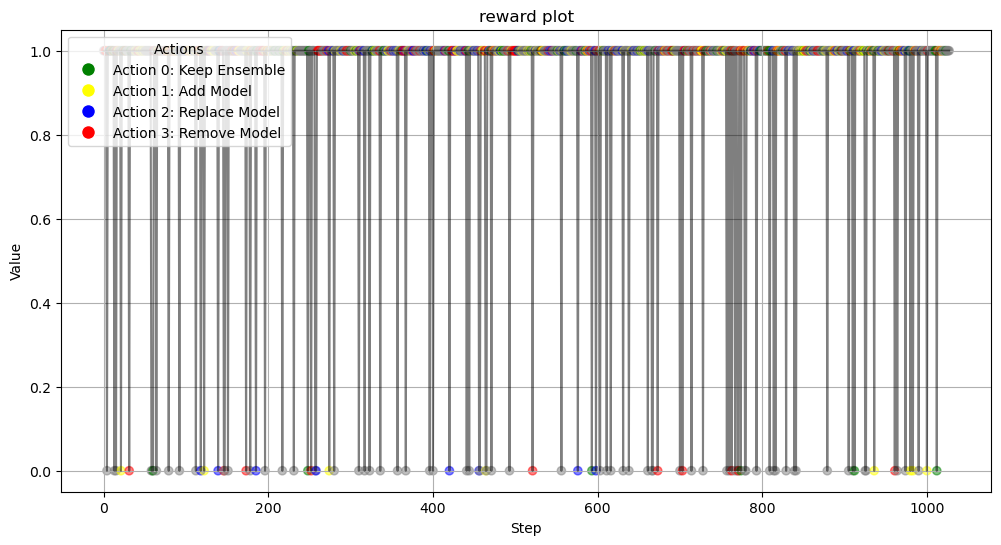

In [60]:
read_reward_column(csv_file_path, "reward")

### In more detail

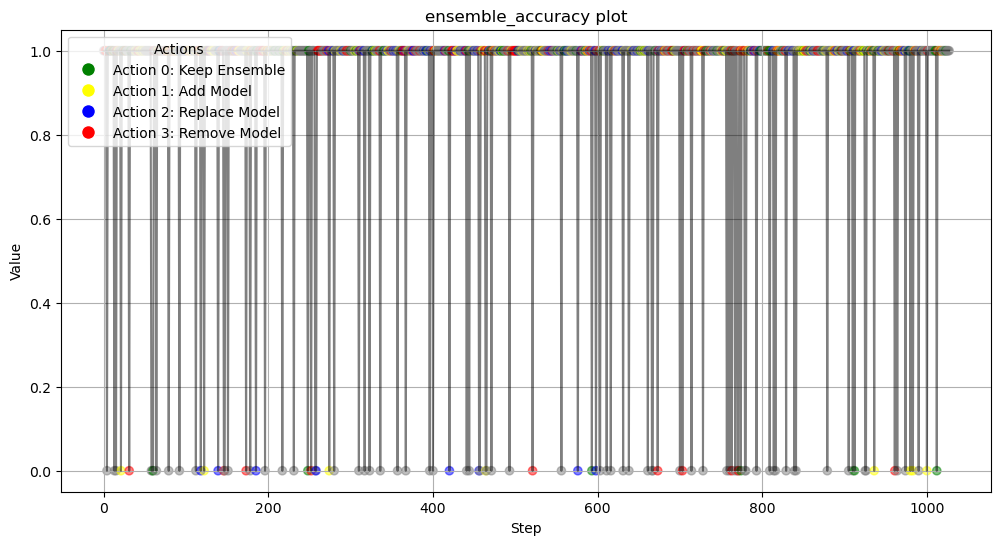

In [61]:
read_reward_column(csv_file_path, "ensemble_accuracy")

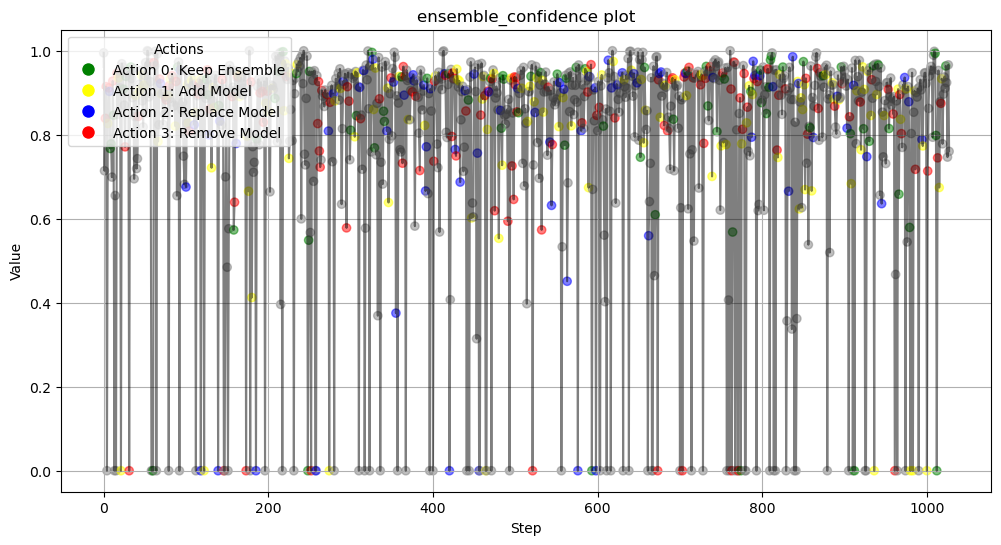

In [62]:
read_reward_column(csv_file_path, "ensemble_confidence")

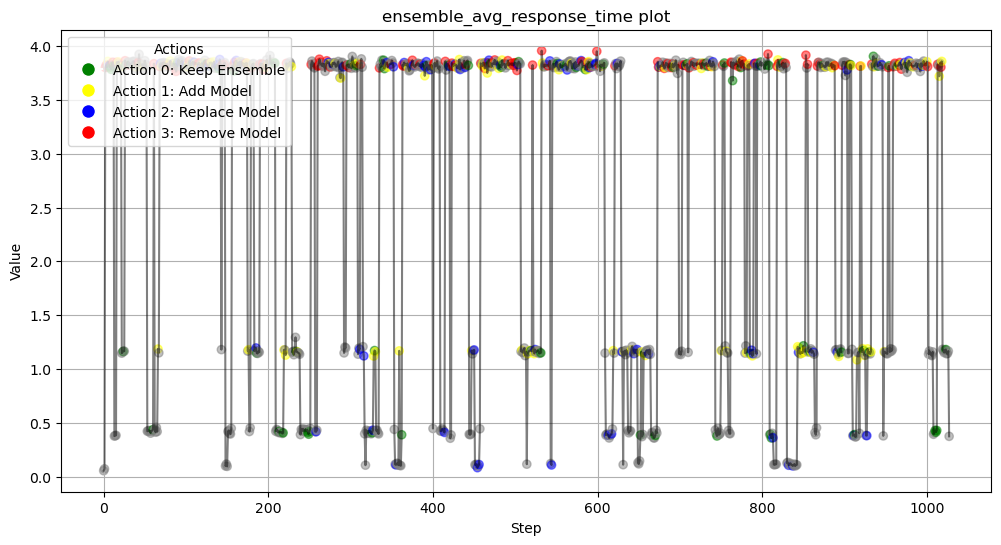

In [63]:
read_reward_column(csv_file_path, "ensemble_avg_response_time")

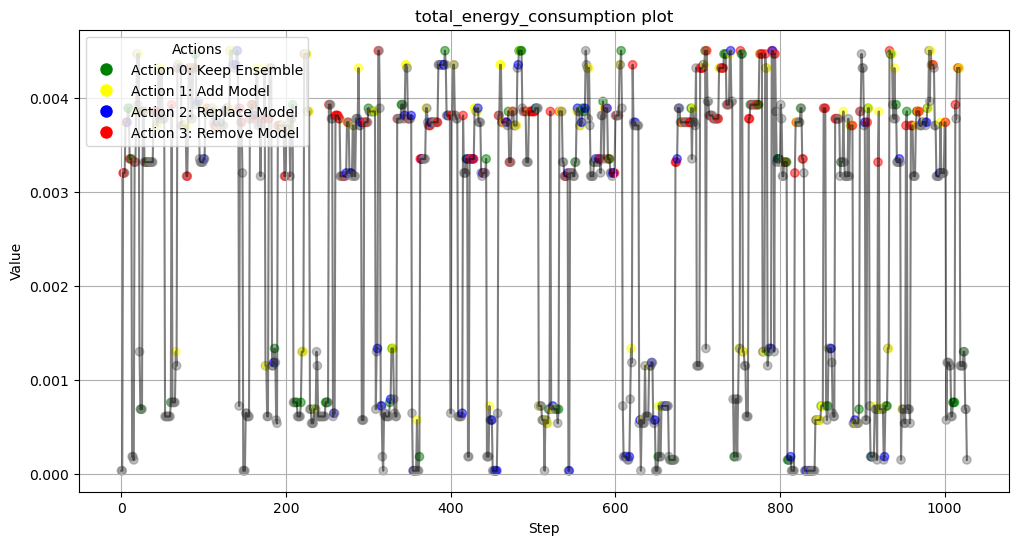

In [64]:
read_reward_column(csv_file_path, "total_energy_consumption")

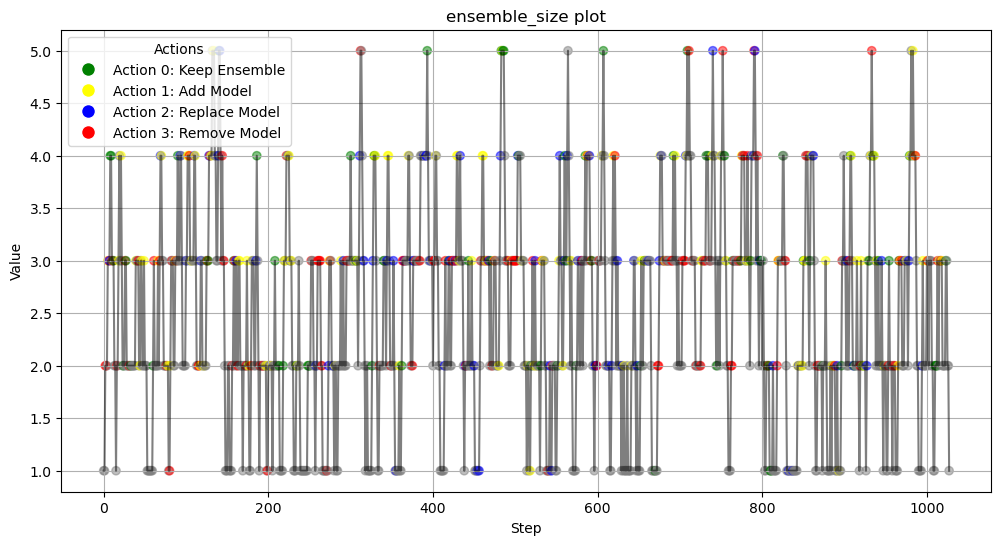

In [65]:
read_reward_column(csv_file_path, "ensemble_size")